In [1]:
!pip install stable-baselines3[extra]
!pip install stable-baselines3
!pip install opencv-python
!pip install gym
!pip install gym[atari] ale-py
!pip install autorom
!pip install "gym[atari,accept-rom-license]"
!pip uninstall gymnasium gym ale-py autorom -y
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install pygame



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.1
    Uninstalling ale-py-0.10.1:
      Successfully uninstalled ale-py-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 24.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=5cee21de9616bf76651fca5be8319e7a2534ff5d8bda5eb036e8da525e4477a4
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully 

In [2]:
#Testing the Taxi environment without training(to check if environment exists)
import gymnasium as gym
import time

# Create the Taxi environment
env = gym.make("Taxi-v3", render_mode="human")

# Reset the environment
obs, info = env.reset()

done = False
start_time = time.time()  # Start the timer
max_time = 120  # 2 minutes (120 seconds)

# Run the environment for one episode or until 2 minutes have passed
while not done:
    # Check if 2 minutes have passed
    if time.time() - start_time > max_time:
        done = True  # End the game after 2 minutes

    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)  # Updated step method
    done = terminated or truncated  # Combine termination and truncation conditions

    #Add delay to make visualization easier
    time.sleep(0.05)

# Print the final score after 2 minutes
print(f"Game ended after 2 minutes. Final Score: {reward}")

env.close()


Game ended after 2 minutes. Final Score: -10


# DQN

In [3]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import tqdm
import pickle  # For saving training data

# Neural Network for Q-Function Approximation
class QNetwork(nn.Module):
    def __init__(self, n_states, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(n_states, 64)  # Input layer size based on state space size
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [4]:
# Initialize environment, model, and hyperparameters
env = gym.make("Taxi-v3")
n_actions = env.action_space.n
n_states = env.observation_space.n  # This is the number of possible states (500 states)

# Initialize Q-network and target network
q_network = QNetwork(n_states, n_actions)
target_network = QNetwork(n_states, n_actions)
target_network.load_state_dict(q_network.state_dict())  # Initialize target network with same weights

optimizer = optim.Adam(q_network.parameters(), lr=0.001)
criterion = nn.MSELoss()



In [5]:
# Hyperparameters
epsilon = 0.1
alpha = 0.01
gamma = 0.9
batch_size = 32
n_episodes = 8000
max_steps = 100

# Experience Replay Buffer
replay_buffer = deque(maxlen=10000)


In [6]:

# Metrics for visualization
rewards_per_episode = []
losses_per_episode = []

# Training loop
for episode in tqdm.tqdm(range(n_episodes), desc="Training Taxi-v3", unit="episode"):
    state, info = env.reset()
    state_tensor = torch.zeros(n_states)  # Initialize a zero tensor for one-hot encoding
    state_tensor[state] = 1  # One-hot encode the state index
    done = False
    total_reward = 0
    losses = []

    for step in range(max_steps):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(range(n_actions))  # Explore
        else:
            with torch.no_grad():
                action = torch.argmax(q_network(state_tensor)).item()  # Exploit

        # Take the action
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        # One-hot encode the next state
        next_state_tensor = torch.zeros(n_states)
        next_state_tensor[next_state] = 1

        # Store the transition in the replay buffer
        replay_buffer.append((state_tensor, action, reward, next_state_tensor, terminated or truncated))

        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer) > batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.stack(states)
            next_states = torch.stack(next_states)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            # Q-value computation
            with torch.no_grad():
                target_q_values = target_network(next_states)
                max_next_q_values = torch.max(target_q_values, dim=1)[0]
                target = rewards + gamma * max_next_q_values * (1 - dones)

            # Get the current Q-values from the model
            current_q_values = q_network(states)
            action_q_values = current_q_values.gather(1, torch.tensor(actions).view(-1, 1))

            # Compute the loss and perform backpropagation
            loss = criterion(action_q_values, target.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        state_tensor = next_state_tensor

        if terminated or truncated:
            break

    # Update target network
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())  # Copy Q-network weights to target network

    # Log episode metrics
    rewards_per_episode.append(total_reward)
    losses_per_episode.append(np.mean(losses) if losses else 0)

    # Save the trained model every 1000 episodes
    if (episode + 1) % 1000 == 0:
        save_path = f"dqn_taxi_episode_{episode+1}.pth"
        torch.save(q_network.state_dict(), save_path)
        print(f"Model saved after {episode+1} episodes to {save_path}.")

# Save the final trained model
#torch.save(q_network.state_dict(), "dqn_taxi_final.pth")
print("Training completed and final model saved!")

# Save metrics for visualization
with open("training_metrics.pkl", "wb") as f:
    pickle.dump({"rewards": rewards_per_episode, "losses": losses_per_episode}, f)
print("Training metrics saved!")


Training Taxi-v3:  12%|█▏        | 999/8000 [03:42<12:28,  9.35episode/s]

Model saved after 1000 episodes to dqn_taxi_episode_1000.pth.


Training Taxi-v3:  25%|██▌       | 2002/8000 [04:36<04:14, 23.57episode/s]

Model saved after 2000 episodes to dqn_taxi_episode_2000.pth.


Training Taxi-v3:  38%|███▊      | 3003/8000 [05:21<03:28, 23.99episode/s]

Model saved after 3000 episodes to dqn_taxi_episode_3000.pth.


Training Taxi-v3:  50%|█████     | 4004/8000 [06:05<02:35, 25.76episode/s]

Model saved after 4000 episodes to dqn_taxi_episode_4000.pth.


Training Taxi-v3:  63%|██████▎   | 5002/8000 [06:47<01:56, 25.73episode/s]

Model saved after 5000 episodes to dqn_taxi_episode_5000.pth.


Training Taxi-v3:  75%|███████▌  | 6004/8000 [07:30<01:15, 26.31episode/s]

Model saved after 6000 episodes to dqn_taxi_episode_6000.pth.


Training Taxi-v3:  88%|████████▊ | 7005/8000 [08:16<00:41, 23.91episode/s]

Model saved after 7000 episodes to dqn_taxi_episode_7000.pth.


Training Taxi-v3: 100%|██████████| 8000/8000 [08:59<00:00, 14.83episode/s]

Model saved after 8000 episodes to dqn_taxi_episode_8000.pth.
Training completed and final model saved!
Training metrics saved!


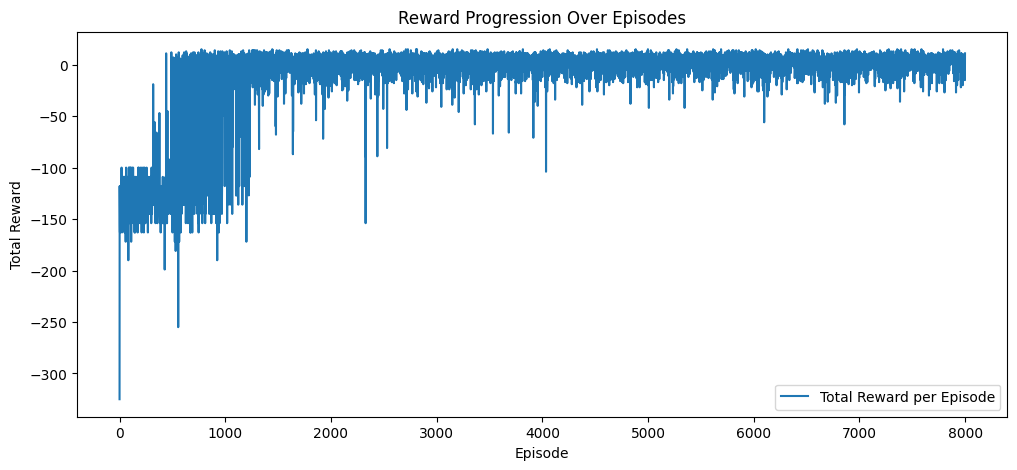

In [29]:
import pickle
import matplotlib.pyplot as plt

# Load training metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

rewards = metrics["rewards"]
losses = metrics["losses"]

# Plot rewards
plt.figure(figsize=(12, 5))
plt.plot(rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Progression Over Episodes")
plt.legend()
plt.show()




# SARSA Algorithm

In [8]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt

# SARSA Algorithm Implementation with Progress Bar and Model Saving
def train_sarsa_with_progress(env, num_episodes=8000, alpha=0.1, gamma=0.99, epsilon=0.1, save_path="sarsa_model.pkl", save_every=1000):
    """
    Train a SARSA agent on the given environment with a progress bar.

    Parameters:
        env: The environment to train on.
        num_episodes: Number of episodes to train for.
        alpha: Learning rate.
        gamma: Discount factor.
        epsilon: Exploration rate.
        save_path: Path to save the Q-table.
        save_every: Number of episodes after which the Q-table is saved.

    Returns:
        Q: The learned Q-table.
        rewards: List of rewards per episode.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Initialize Q-table
    Q = np.zeros((n_states, n_actions))
    rewards = []
    losses = []  # Track updates (proxy for loss)

    # Use tqdm to show progress
    for episode in tqdm(range(num_episodes), desc="Training SARSA", unit="episode"):
        state, info = env.reset()
        action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[state])
        total_reward = 0
        done = False

        while not done:
            # Take action, observe new state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Choose next action using epsilon-greedy policy
            next_action = np.random.choice(n_actions) if np.random.rand() < epsilon else np.argmax(Q[next_state])

            # Compute the TD error (proxy for loss)
            td_error = reward + gamma * Q[next_state, next_action] - Q[state, action]
            losses.append(abs(td_error))  # Track absolute TD error

            # Update Q-value using SARSA update rule
            Q[state, action] += alpha * td_error

            # Move to next state and action
            state = next_state
            action = next_action

        rewards.append(total_reward)

        # Save the Q-table every `save_every` episodes
        if (episode + 1) % save_every == 0:
            save_q_table(Q, f"sarsa_model_episode_{episode+1}.pkl")
            print(f"Model saved at episode {episode + 1}")

    # Save the final Q-table
    save_q_table(Q, save_path)
    return Q, rewards, losses




In [9]:
def save_q_table(Q, path):
    """Save Q-table to a file."""
    with open(path, "wb") as file:
        pickle.dump(Q, file)
    print(f"Q-table saved at: {path}")


def load_q_table(path):
    """Load Q-table from a file."""
    if os.path.exists(path):
        with open(path, "rb") as file:
            Q = pickle.load(file)
        print(f"Q-table loaded from: {path}")
        return Q
    else:
        print(f"No Q-table found at: {path}. Starting fresh.")
        return None




In [30]:
def plot_training_data(rewards, losses, reward_path="rewards_plot.png", loss_path="loss_plot.png"):
    """Plot rewards and losses."""
    # Plot rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards Over Episodes")
    plt.savefig(reward_path)
    plt.show()





In [11]:
# Initialize Taxi-v3 environment
env = gym.make("Taxi-v3")

q_table_path = "sarsa_model.pkl"

# Train SARSA agent or load existing Q-table
if os.path.exists(q_table_path):
    Q_table = load_q_table(q_table_path)
else:
    Q_table, rewards, losses = train_sarsa_with_progress(env, num_episodes=8000, save_path=q_table_path)

    # Save rewards and losses for further analysis
    np.save("rewards.npy", rewards)
    np.save("losses.npy", losses)
    print("Training data saved for visualization.")




Training SARSA:  14%|█▍        | 1137/8000 [00:02<00:07, 873.52episode/s]

Q-table saved at: sarsa_model_episode_1000.pkl
Model saved at episode 1000


Training SARSA:  28%|██▊       | 2211/8000 [00:03<00:03, 1593.59episode/s]

Q-table saved at: sarsa_model_episode_2000.pkl
Model saved at episode 2000


Training SARSA:  41%|████▏     | 3315/8000 [00:04<00:03, 1522.86episode/s]

Q-table saved at: sarsa_model_episode_3000.pkl
Model saved at episode 3000


Training SARSA:  52%|█████▏    | 4162/8000 [00:04<00:02, 1569.40episode/s]

Q-table saved at: sarsa_model_episode_4000.pkl
Model saved at episode 4000


Training SARSA:  66%|██████▌   | 5265/8000 [00:05<00:01, 1431.51episode/s]

Q-table saved at: sarsa_model_episode_5000.pkl
Model saved at episode 5000


Training SARSA:  77%|███████▋  | 6174/8000 [00:06<00:01, 1486.50episode/s]

Q-table saved at: sarsa_model_episode_6000.pkl
Model saved at episode 6000


Training SARSA:  93%|█████████▎| 7469/8000 [00:07<00:00, 1863.22episode/s]

Q-table saved at: sarsa_model_episode_7000.pkl
Model saved at episode 7000


Training SARSA: 100%|██████████| 8000/8000 [00:07<00:00, 1097.98episode/s]

Q-table saved at: sarsa_model_episode_8000.pkl
Model saved at episode 8000
Q-table saved at: sarsa_model.pkl
Training data saved for visualization.


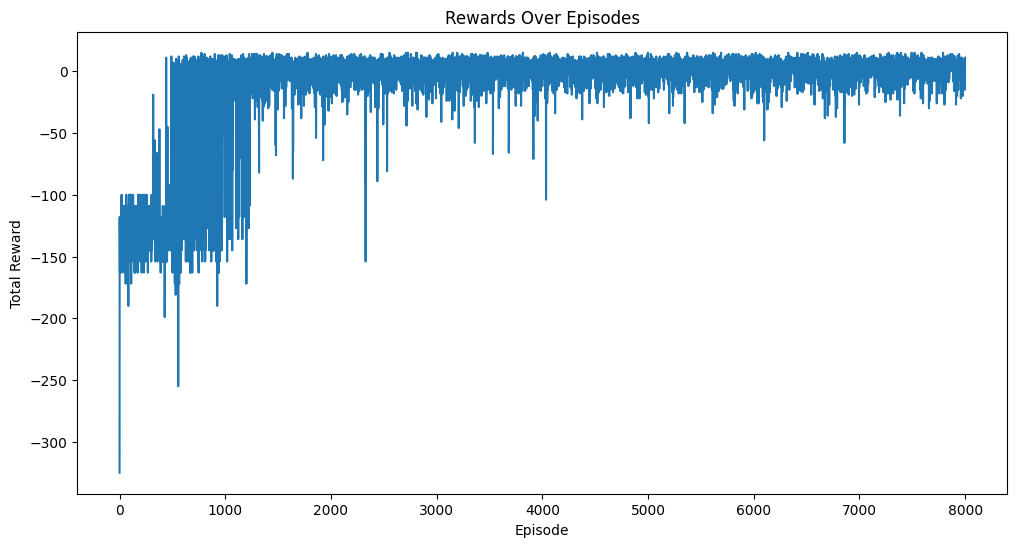

In [31]:
plot_training_data(rewards, losses)


# Q-Learning Algorithm

In [13]:
# Training the RL agent using Q-Learning Algorithm
import gymnasium as gym
import numpy as np
import random
import tqdm
import pickle
import matplotlib.pyplot as plt

def train_q_learning(env, n_episodes=8000, alpha=0.1, gamma=0.9, epsilon=0.1, save_every=1000, save_path="taxi_q_table.pkl"):
    """
    Train a Q-Learning agent and save progress periodically.

    Parameters:
        env: The environment to train on.
        n_episodes: Number of episodes for training.
        alpha: Learning rate.
        gamma: Discount factor.
        epsilon: Exploration-exploitation trade-off.
        save_every: Save model every 'save_every' episodes.
        save_path: File path to save the final Q-table.

    Returns:
        q_table: Trained Q-table.
        rewards: List of rewards per episode.
    """
    n_actions = env.action_space.n
    n_states = env.observation_space.n
    q_table = np.zeros((n_states, n_actions))  # Initialize Q-table with zeros
    rewards = []  # Store rewards for visualization

    # Training loop
    for episode in tqdm.tqdm(range(n_episodes), desc="Training Progress", unit="episode"):
        state, info = env.reset()
        done = False
        total_reward = 0

        for _ in range(100):  # Maximum steps per episode
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(q_table[state, :])  # Exploit

            # Take the action and observe the outcome
            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward

            # Update the Q-table using the Q-learning formula
            q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])

            state = next_state  # Transition to the next state

            if terminated or truncated:
                break

        rewards.append(total_reward)

        # Save the Q-table every `save_every` episodes
        if (episode + 1) % save_every == 0:
            save_q_table(q_table, f"taxi_q_table_episode_{episode + 1}.pkl")
            print(f"Q-table saved at episode {episode + 1}")

    # Save the final Q-table
    save_q_table(q_table, save_path)
    return q_table, rewards




In [14]:
def save_q_table(q_table, path):
    """Save Q-table to a file."""
    with open(path, "wb") as f:
        pickle.dump(q_table, f)
    print(f"Q-table saved at: {path}")


def load_q_table(path):
    """Load Q-table from a file."""
    try:
        with open(path, "rb") as f:
            q_table = pickle.load(f)
        print(f"Q-table loaded from: {path}")
        return q_table
    except FileNotFoundError:
        print(f"No Q-table found at: {path}. Starting fresh.")
        return None




In [15]:
def plot_rewards(rewards, save_path="rewards_plot.png"):
    """Plot rewards over episodes."""
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards Over Episodes")
    plt.savefig(save_path)
    plt.show()
    print(f"Reward plot saved at: {save_path}")





In [22]:
# Main Execution
import os
env = gym.make("Taxi-v3")

# Train the agent
q_table_path = "taxi_q_table_fin.pkl"
if os.path.exists(q_table_path):
    q_table = load_q_table(q_table_path)
else:
    q_table, rewards = train_q_learning(env, n_episodes=8000, alpha=0.1, gamma=0.9, epsilon=0.1)

    # Save rewards for visualization
    np.save("q_learning_rewards.npy", rewards)

# Close the environment
env.close()

Training Progress:  13%|█▎        | 1047/8000 [00:02<00:15, 447.35episode/s]

Q-table saved at: taxi_q_table_episode_1000.pkl
Q-table saved at episode 1000


Training Progress:  28%|██▊       | 2214/8000 [00:04<00:04, 1195.71episode/s]

Q-table saved at: taxi_q_table_episode_2000.pkl
Q-table saved at episode 2000


Training Progress:  42%|████▏     | 3327/8000 [00:04<00:02, 1639.67episode/s]

Q-table saved at: taxi_q_table_episode_3000.pkl
Q-table saved at episode 3000


Training Progress:  54%|█████▍    | 4346/8000 [00:05<00:01, 2032.31episode/s]

Q-table saved at: taxi_q_table_episode_4000.pkl
Q-table saved at episode 4000


Training Progress:  65%|██████▌   | 5207/8000 [00:05<00:01, 2081.28episode/s]

Q-table saved at: taxi_q_table_episode_5000.pkl
Q-table saved at episode 5000


Training Progress:  78%|███████▊  | 6208/8000 [00:06<00:01, 1782.74episode/s]

Q-table saved at: taxi_q_table_episode_6000.pkl
Q-table saved at episode 6000


Training Progress:  90%|█████████ | 7220/8000 [00:07<00:00, 1824.92episode/s]

Q-table saved at: taxi_q_table_episode_7000.pkl
Q-table saved at episode 7000


Training Progress: 100%|██████████| 8000/8000 [00:07<00:00, 1067.03episode/s]

Q-table saved at: taxi_q_table_episode_8000.pkl
Q-table saved at episode 8000
Q-table saved at: taxi_q_table.pkl


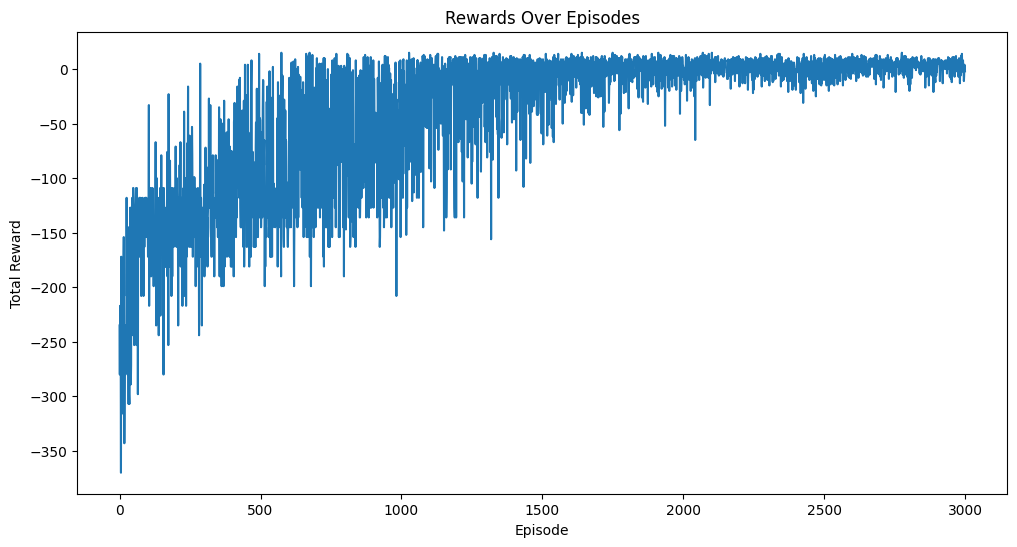

In [17]:
# Plot rewards
plot_rewards(rewards)


# Q Learning q-table

In [18]:
import pandas as pd
import pickle

# Load Q-table
with open("taxi_q_table.pkl", "rb") as file:
    q_table = pickle.load(file)

# Create a DataFrame
df = pd.DataFrame(q_table, columns=["Action 0", "Action 1", "Action 2", "Action 3", "Action 4", "Action 5"])
df.index.name = "State"

# Display the DataFrame
df

Reward plot saved at: rewards_plot.png


,Action 0,Action 1,Action 2,Action 3,Action 4,Action 5
State,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-2.170319,-2.645293,-3.194792,-2.256070,1.622558,-5.764614
2,-1.530537,-0.473118,0.647951,1.385148,7.714692,-2.968623
3,-2.015288,-1.724590,-3.082905,-1.222533,2.913515,-5.976768
4,-5.793324,-5.775710,-5.784799,-5.763019,-6.486885,-8.052940
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.519423,-2.501956,-2.523468,0.238115,-4.662612,-4.608683
497,-1.224790,2.343357,-1.224413,-1.267661,-1.990000,-1.984548


# SARSA q-table

In [19]:
import pandas as pd
import pickle

# Load Q-table
with open("sarsa_model.pkl", "rb") as file:
    q_table = pickle.load(file)

# Create a DataFrame
df = pd.DataFrame(q_table, columns=["Action 0", "Action 1", "Action 2", "Action 3", "Action 4", "Action 5"])
df.index.name = "State"

# Display the DataFrame
df

,Action 0,Action 1,Action 2,Action 3,Action 4,Action 5
State,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-2.162472,-1.718578,-1.607748,-1.571019,4.562429,-6.445431
2,2.972126,4.904904,0.607184,4.490277,10.355404,-1.741756
3,-1.566306,-0.328486,-2.305999,-0.180737,5.470923,-5.444550
4,-8.237968,-8.666264,-8.941820,-8.583054,-10.917352,-10.353009
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.605741,-2.680743,-3.143551,2.846813,-5.484130,-4.691636
497,-1.551611,-1.467458,-1.579955,5.224879,-3.141766,-2.806092


In [28]:
import torch
import pickle
import numpy as np
import gymnasium as gym

# Load models
def load_dqn_model(path, n_states, n_actions):
    class QNetwork(torch.nn.Module):
        def __init__(self, n_states, n_actions):
            super(QNetwork, self).__init__()
            self.fc1 = torch.nn.Linear(n_states, 64)
            self.fc2 = torch.nn.Linear(64, 64)
            self.fc3 = torch.nn.Linear(64, n_actions)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return self.fc3(x)

    model = QNetwork(n_states, n_actions)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def load_sarsa_model(path):
    with open(path, "rb") as f:
        q_table = pickle.load(f)
    return q_table

def load_q_learning_model(path):
    with open(path, "rb") as f:
        q_table = pickle.load(f)
    return q_table

# Evaluate a model
def evaluate_model(env, model_type, model, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        while not done:
            if model_type == "dqn":
                # One-hot encode the state for DQN
                state_tensor = torch.zeros(env.observation_space.n)
                state_tensor[state] = 1
                with torch.no_grad():
                    action = torch.argmax(model(state_tensor)).item()
            elif model_type in ["sarsa", "q_learning"]:
                # Choose action based on Q-table
                action = np.argmax(model[state])
            else:
                raise ValueError("Unsupported model type")

            # Step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
            done = terminated or truncated

        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

# Main
if __name__ == "__main__":
    env = gym.make("Taxi-v3")
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Load the models
    dqn_model = load_dqn_model("dqn_taxi_episode_8000.pth", n_states, n_actions)
    sarsa_model = load_sarsa_model("sarsa_model_episode_8000.pkl")
    q_learning_model = load_q_learning_model("/content/taxi_q_table_episode_8000.pkl")

    # Evaluate the models
    dqn_avg_reward = evaluate_model(env, "dqn", dqn_model)
    sarsa_avg_reward = evaluate_model(env, "sarsa", sarsa_model)
    q_learning_avg_reward = evaluate_model(env, "q_learning", q_learning_model)

    # Print results
    print(f"Average Reward for DQN: {dqn_avg_reward}")
    print(f"Average Reward for SARSA: {sarsa_avg_reward}")
    print(f"Average Reward for Q-Learning: {q_learning_avg_reward}")

    env.close()


<ipython-input-28-0d50c2390348>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Average Reward for DQN: 8.12
Average Reward for SARSA: 7.63
Average Reward for Q-Learning: 7.97
